In [ ]:
import torch as tc
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import torchvision as tv
from torchvision.transforms import transforms as T
from torchvision.models import resnet18
from torchvision.datasets import CIFAR100

from torchmetrics import Accuracy

import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [ ]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [ ]:
train_transforms = T.Compose([T.RandomCrop(32, 4),
                              T.RandomHorizontalFlip(),
                              T.ToTensor(),
                              T.Normalize(mean = (0.4194, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010))])
test_transforms = T.Compose([T.ToTensor(),
                             T.Normalize(mean = (0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010))])

In [ ]:
train_dataset = CIFAR100(root = '/home/ahmadrezabaqerzadeh/datasets/', download = True, train = True, transform = train_transforms)
test_dataset  = CIFAR100(root = '/home/ahmadrezabaqerzadeh/datasets/', download = True, train = False, transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [ ]:
#Model

In [ ]:
net    = resnet18()
net.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(512, 100))
model  = net.to(device)

In [ ]:
def num_parameters(model):
    n = sum([p.numel() for p in model.parameters() if p.requires_grad])/1e6
    return print(str(n) + 'M')

In [ ]:
num_parameters(model)

11.227812M


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#loss function and optimizer

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)#, weight_decay = 5e-4)

#sheduler  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)

In [ ]:
#test on 1 batch

In [ ]:
x, y = next(iter(train_loader))
yp   = model(x.to(device))
loss_func(yp, y.to(device))

tensor(5.3334, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
base_lr = 1e-3

In [ ]:
params = [
    {'params':model.conv1.parameters(), 'lr': base_lr/10},
    {'params':model.bn1.parameters()  , 'lr': base_lr/10},
    {'params':model.layer1.parameters(), 'lr': base_lr/8},
    {'params':model.layer2.parameters(), 'lr': base_lr/6},
    {'params':model.layer3.parameters(), 'lr': base_lr/4},
    {'params':model.layer4.parameters(), 'lr': base_lr/2},
    {'params':model.fc.parameters()},
]
params1 = [
    {'params':model.conv1.parameters(), 'lr': base_lr/10}
]

optimizer = optim.Adam(params, lr = base_lr)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, optimizer, loss_func, epoch):

    model.train()

    loss      = AverageMeter()
    accuracy  = Accuracy(task = 'multiclass', num_classes = 100).to(device)

    with tqdm(train_loader, unit = 'batch') as tepoch:

        for x,y in tepoch:

            if epoch is not None:

                tepoch.set_description(f'epoch{epoch}')

            x = x.to(device)
            y = y.to(device)

            ypred = model(x)
            error = loss_func(ypred,  y)
            error.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.update(error)
            accuracy(ypred, y)

            tepoch.set_postfix(loss = loss.avg.item(), accuracy = accuracy.compute().item() * 100)

    return model, loss.avg.item(), accuracy.compute().item()

In [ ]:
def validation(model, valid_loader, loss_func):

    model.eval()

    loss = AverageMeter()
    accuracy = Accuracy(task = 'multiclass', num_classes = 100).to(device)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)

        ypred = model(x)
        error = loss_func(ypred, y)

        loss.update(error)
        accuracy(ypred.squeeze(), y)

    print(f'valid_loss = {loss.avg : .4}, accuracy = {accuracy.compute().item() * 100 : .4}')

    return loss.avg.item(), accuracy.compute().item() * 100


In [ ]:
#from torch.utils.tensorboard import summaryWriter

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir runs

In [ ]:
import logging

In [ ]:
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('CIFAR100-resnet18')

In [ ]:
logger.info('This is an info message')
logging.warning('This is an warning message')
logging.error('This is an error message')
logging.critical('This is an critical message')

INFO:CIFAR100-resnet18:This is an info message
ERROR:root:This is an error message
CRITICAL:root:This is an critical message


In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 5e-4)

In [ ]:
loss_train_hist, acc_train_hist = [], []
loss_val_hist  , acc_val_hist   = [], []
N = 20
best_loss = tc.inf
best_model = 0

In [ ]:
for epoch in range(N):

    model, train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_func, epoch)
    val_loss, val_acc            = validation(model, test_loader, loss_func)

    loss_train_hist.append(train_loss)
    acc_train_hist.append(train_acc)

    loss_val_hist.append(val_loss)
    acc_val_hist.append(val_acc)

    if val_loss<best_loss:
        best_model = model
        best_loss  = val_loss
        print('model saved!')


epoch0: 100%|██████████| 782/782 [00:45<00:00, 17.29batch/s, accuracy=70.9, loss=0.998]


valid_loss =  1.716, accuracy =  56.16


epoch1: 100%|██████████| 782/782 [00:46<00:00, 16.91batch/s, accuracy=72.6, loss=0.944]


valid_loss =  1.73, accuracy =  56.0


epoch2: 100%|██████████| 782/782 [00:46<00:00, 16.95batch/s, accuracy=73.7, loss=0.908]


valid_loss =  1.747, accuracy =  56.18


epoch3: 100%|██████████| 782/782 [00:45<00:00, 17.21batch/s, accuracy=74.1, loss=0.885]


valid_loss =  1.8, accuracy =  55.39


epoch4: 100%|██████████| 782/782 [00:45<00:00, 17.17batch/s, accuracy=74.9, loss=0.855]


valid_loss =  1.78, accuracy =  55.81


epoch5: 100%|██████████| 782/782 [00:49<00:00, 15.76batch/s, accuracy=75.4, loss=0.844]


valid_loss =  1.785, accuracy =  56.04


epoch6: 100%|██████████| 782/782 [00:46<00:00, 16.83batch/s, accuracy=75.3, loss=0.831]


valid_loss =  1.814, accuracy =  55.69


epoch7: 100%|██████████| 782/782 [00:45<00:00, 17.11batch/s, accuracy=76.1, loss=0.814]


valid_loss =  1.772, accuracy =  56.44


epoch8: 100%|██████████| 782/782 [00:46<00:00, 16.85batch/s, accuracy=76.3, loss=0.807]


valid_loss =  1.809, accuracy =  55.94


epoch9: 100%|██████████| 782/782 [00:45<00:00, 17.13batch/s, accuracy=77, loss=0.781]


valid_loss =  1.816, accuracy =  56.28


epoch10: 100%|██████████| 782/782 [00:45<00:00, 17.31batch/s, accuracy=77.1, loss=0.776]


valid_loss =  1.828, accuracy =  56.01


epoch11: 100%|██████████| 782/782 [00:45<00:00, 17.02batch/s, accuracy=77.3, loss=0.769]


valid_loss =  1.833, accuracy =  56.14


epoch12: 100%|██████████| 782/782 [00:45<00:00, 17.19batch/s, accuracy=77.6, loss=0.756]


valid_loss =  1.852, accuracy =  55.66


epoch13: 100%|██████████| 782/782 [00:45<00:00, 17.07batch/s, accuracy=78, loss=0.74]


valid_loss =  1.84, accuracy =  56.23


epoch14: 100%|██████████| 782/782 [00:46<00:00, 16.70batch/s, accuracy=78.5, loss=0.73]


valid_loss =  1.877, accuracy =  55.77


epoch15: 100%|██████████| 782/782 [00:46<00:00, 16.90batch/s, accuracy=78.7, loss=0.717]


valid_loss =  1.842, accuracy =  56.12


epoch16: 100%|██████████| 782/782 [00:45<00:00, 17.00batch/s, accuracy=79.2, loss=0.701]


valid_loss =  1.882, accuracy =  56.28


epoch17: 100%|██████████| 782/782 [00:45<00:00, 17.03batch/s, accuracy=79.3, loss=0.693]


valid_loss =  1.899, accuracy =  55.67


epoch18: 100%|██████████| 782/782 [00:46<00:00, 16.81batch/s, accuracy=79.9, loss=0.679]


valid_loss =  1.896, accuracy =  55.97


epoch19: 100%|██████████| 782/782 [00:45<00:00, 17.01batch/s, accuracy=79.6, loss=0.68]


valid_loss =  1.909, accuracy =  55.52


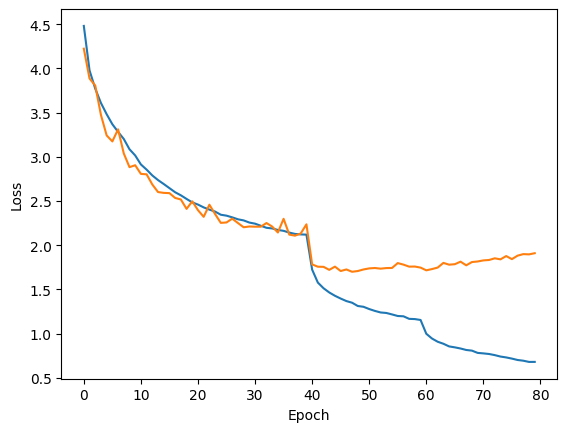

1.699484944343567

In [ ]:
plt.plot(range(N * 4), loss_train_hist, label = 'train loss')
plt.plot(range(N * 4), loss_val_hist, label =  'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
min(loss_val_hist)

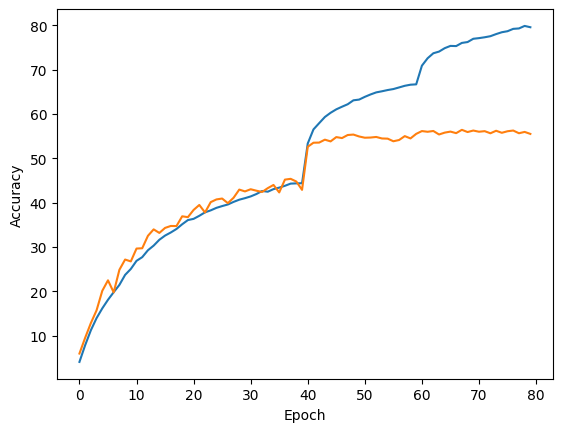

In [ ]:
plt.plot(range(N * 4), [100 * p for p in acc_train_hist], label = 'train loss')
plt.plot(range(N * 4), acc_val_hist, label =  'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()